In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN, Flatten
from tensorflow.keras.regularizers import l2

In [15]:
data = pd.read_csv('../raw_data/merged_data.csv')
data

,text,is_fake
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1
...,...,...
38653,NATO allies on Tuesday welcomed President Dona...,0
38654,"LexisNexis, a provider of legal, regulatory an...",0
38655,In the shadow of disused Soviet-era factories ...,0
38656,Vatican Secretary of State Cardinal Pietro Par...,0


In [16]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def cleaning(sentence):
    
    # Basic cleaning
    sentence = sentence.strip() ## remove whitespaces
    sentence = sentence.lower() ## lowercase 
    sentence = ''.join(char for char in sentence if not char.isdigit()) ## remove numbers
    
    # Advanced cleaning
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '') ## remove punctuation
    
    tokenized_sentence = word_tokenize(sentence) ## tokenize 
    stop_words = set(stopwords.words('english')) ## define stopwords
    
    tokenized_sentence_cleaned = [ ## remove stopwords
        w for w in tokenized_sentence if not w in stop_words
    ]

    lemmatized = [
        WordNetLemmatizer().lemmatize(word, pos = "v") 
        for word in tokenized_sentence_cleaned
    ]
    
    cleaned_sentence = ' '.join(word for word in lemmatized)
    
    return cleaned_sentence

In [17]:
%%time

data['text_clean'] = data['text'].apply(cleaning)
data

CPU times: user 1min 52s, sys: 2.52 s, total: 1min 55s
Wall time: 1min 55s


,text,is_fake,text_clean
0,Donald Trump just couldn t wish all Americans ...,1,donald trump wish americans happy new year lea...
1,House Intelligence Committee Chairman Devin Nu...,1,house intelligence committee chairman devin nu...
2,"On Friday, it was revealed that former Milwauk...",1,friday reveal former milwaukee sheriff david c...
3,"On Christmas day, Donald Trump announced that ...",1,christmas day donald trump announce would back...
4,Pope Francis used his annual Christmas Day mes...,1,pope francis use annual christmas day message ...
...,...,...,...
38653,NATO allies on Tuesday welcomed President Dona...,0,nato ally tuesday welcome president donald tru...
38654,"LexisNexis, a provider of legal, regulatory an...",0,lexisnexis provider legal regulatory business ...
38655,In the shadow of disused Soviet-era factories ...,0,shadow disused sovietera factories minsk stree...
38656,Vatican Secretary of State Cardinal Pietro Par...,0,vatican secretary state cardinal pietro paroli...


In [18]:
X = data.text_clean
y = data.is_fake

In [19]:
# Perform a 70:30 split for the initial training set and temporary set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the temporary set into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [20]:
%%time
# max_words = 10000  
# max_sequence_length = 500  

# Initialize the tokenizer and fit it on the training data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

CPU times: user 6.82 s, sys: 75.7 ms, total: 6.9 s
Wall time: 6.94 s


In [21]:
len(word_index)

156905

In [22]:
# Convert text data to sequences of integers
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [23]:
sequences = tokenizer.texts_to_sequences(data.text_clean)

lengths_of_texts =  [len(text) for text in sequences]

## For length to pad till, we use the average length of all texts 
avg_length_text = int(np.mean(lengths_of_texts))

X_train_pad = pad_sequences(X_train_sequences, maxlen=avg_length_text, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_sequences, maxlen=avg_length_text, padding='pre')
X_test_pad = pad_sequences(X_test_sequences, maxlen=avg_length_text, padding='post', truncating='post')

---

## SimpleRNN Model

In [45]:
%%time
from keras.callbacks import EarlyStopping

model_rnn = Sequential([
    Embedding(input_dim = len(word_index), output_dim = 8, 
             input_length=avg_length_text), ## recall that we set the post-padding length to be this value 
    SimpleRNN(16), ## THIS IS THE RECURRENT LAYER 
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.2), 
    Dense(1, activation= 'sigmoid') ## final layer for prediction, hence only one node
])

## compile -- add optim, add loss, add metrics 
model_rnn.compile(optimizer = 'adam', loss = ['binary_crossentropy'], metrics = ['accuracy'])

early_stopping = EarlyStopping(patience=25, restore_best_weights=True)

history_rnn = model_rnn.fit(X_train_pad, y_train, epochs=1000, batch_size=32, validation_data=(X_val_pad, y_val), callbacks=[early_stopping])

Epoch 1/1000
846/846 [==============================] - 39s 44ms/step - loss: 0.6505 - accuracy: 0.5985 - val_loss: 0.6683 - val_accuracy: 0.5515
Epoch 2/1000
846/846 [==============================] - 47s 55ms/step - loss: 0.6429 - accuracy: 0.5962 - val_loss: 0.6415 - val_accuracy: 0.5603
Epoch 3/1000
846/846 [==============================] - 54s 63ms/step - loss: 0.4464 - accuracy: 0.7943 - val_loss: 0.6274 - val_accuracy: 0.7322
Epoch 4/1000
846/846 [==============================] - 45s 53ms/step - loss: 0.3957 - accuracy: 0.8425 - val_loss: 0.4010 - val_accuracy: 0.7934
Epoch 5/1000
846/846 [==============================] - 53s 62ms/step - loss: 0.3018 - accuracy: 0.9017 - val_loss: 0.2158 - val_accuracy: 0.9300
Epoch 6/1000
846/846 [==============================] - 48s 56ms/step - loss: 0.1999 - accuracy: 0.9496 - val_loss: 0.1723 - val_accuracy: 0.9464
Epoch 7/1000
846/846 [==============================] - 47s 56ms/step - loss: 0.2840 - accuracy: 0.9052 - val_loss: 0.2825 -

In [46]:
# Evaluate the model on the test set
loss, accuracy = model_rnn.evaluate(X_test_pad, y_test)

182/182 [==============================] - 2s 10ms/step - loss: 0.1250 - accuracy: 0.9595


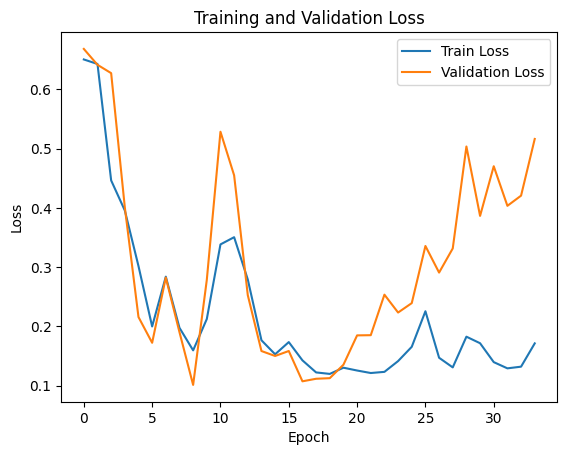

In [47]:
# Plot the training and validation loss
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

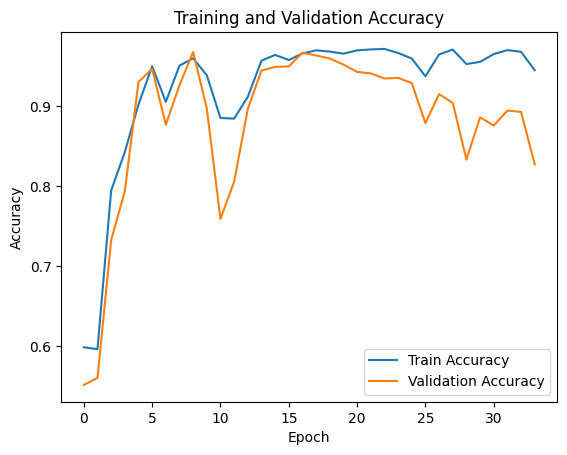

In [48]:
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [49]:
y_pred = model_rnn.predict(X_test_pad)

182/182 [==============================] - 2s 9ms/step


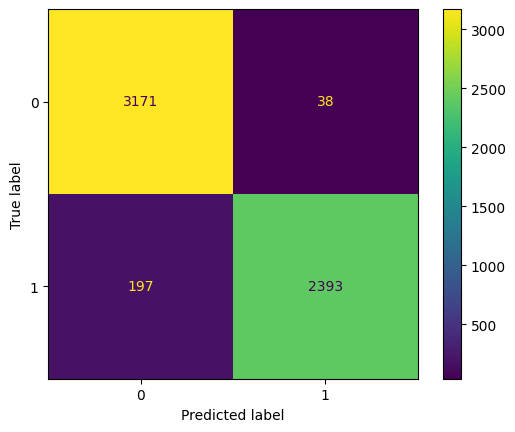

In [50]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf

predicted = tf.squeeze(y_pred)
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(y_test)
conf_mat = confusion_matrix(actual, predicted)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()

---

## Basic NN Model

In [30]:
# model_3 = Sequential([
#     Embedding(input_dim=len(word_index), output_dim=8, input_length=avg_length_text),
#     Flatten(),
#     Dense(8, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
#     Dropout(0.5),  # Adding dropout
#     Dense(1, activation='sigmoid')
# ])

# model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ## Decrease patience, allow restore to best weights during patience
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# history_3 = model_3.fit(X_train_pad, y_train, epochs=50, batch_size=200, validation_data=(X_val_pad, y_test), callbacks=[early_stopping])

In [31]:
# final_train_loss_3 = history_3.history['loss'][-1]
# final_train_accuracy_3 = history_3.history['accuracy'][-1]

# final_val_loss_3 = history_3.history['val_loss'][-1]
# final_val_accuracy_3 = history_3.history['val_accuracy'][-1]

# print("Final Training Loss:", final_train_loss_3)
# print("Final Training Accuracy:", final_train_accuracy_3)
# print("Final Validation Loss:", final_val_loss_3)
# print("Final Validation Accuracy:", final_val_accuracy_3)


In [32]:
# # Plot the training and validation loss
# plt.plot(history_3.history['loss'], label='Train Loss')
# plt.plot(history_3.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [71]:
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical

# Assuming y_train is your target variable
# Convert to one-hot encoding if it's binary classification
y_train_onehot = to_categorical(y_train)

# Define the number of folds
n_folds = 5

# Initialize StratifiedKFold
stratkf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists to store results from each fold
all_train_histories = []
all_val_histories = []

# Loop over the folds
for fold, (train_index, val_index) in enumerate(stratkf.split(X_train_pad, y_train)):
    print(f"Training on fold {fold + 1}...")

    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train_pad[train_index], X_train_pad[val_index]
    y_train_fold, y_val_fold = y_train_onehot[train_index], y_train_onehot[val_index]

    # Build your model (same as before)
    model_rnn = Sequential([
        Embedding(input_dim=len(word_index), output_dim=8, input_length=avg_length_text),
        SimpleRNN(16),
        Dropout(0.2),
        Dense(8, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')  # Adjust for one-hot encoded labels
    ])

    # Compile the model
    model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(patience=25, restore_best_weights=True)

    # Train the model on this fold
    history_rnn = model_rnn.fit(
        X_train_fold, y_train_fold,
        epochs=1000, batch_size=32,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping]
    )

    # Store training history for this fold
    all_train_histories.append(history_rnn.history['loss'])
    all_val_histories.append(history_rnn.history['val_loss'])

Training on fold 1...
Epoch 1/1000
677/677 [==============================] - 43s 62ms/step - loss: 0.6291 - accuracy: 0.6420 - val_loss: 0.5293 - val_accuracy: 0.7515
Epoch 2/1000
677/677 [==============================] - 35s 52ms/step - loss: 0.3251 - accuracy: 0.8854 - val_loss: 0.1744 - val_accuracy: 0.9549
Epoch 3/1000
677/677 [==============================] - 41s 60ms/step - loss: 0.2915 - accuracy: 0.9158 - val_loss: 0.2274 - val_accuracy: 0.9350
Epoch 4/1000
677/677 [==============================] - 41s 61ms/step - loss: 0.2126 - accuracy: 0.9490 - val_loss: 0.2232 - val_accuracy: 0.9359
Epoch 5/1000
677/677 [==============================] - 36s 53ms/step - loss: 0.1867 - accuracy: 0.9569 - val_loss: 0.2092 - val_accuracy: 0.9420
Epoch 6/1000
677/677 [==============================] - 36s 53ms/step - loss: 0.2860 - accuracy: 0.8848 - val_loss: 0.1687 - val_accuracy: 0.9599
Epoch 7/1000
677/677 [==============================] - 36s 53ms/step - loss: 0.1600 - accuracy: 0.964

677/677 [==============================] - 36s 53ms/step - loss: 0.0181 - accuracy: 0.9945 - val_loss: 0.1306 - val_accuracy: 0.9666
Epoch 25/1000
677/677 [==============================] - 51s 75ms/step - loss: 0.0094 - accuracy: 0.9979 - val_loss: 0.1309 - val_accuracy: 0.9712
Epoch 26/1000
677/677 [==============================] - 36s 53ms/step - loss: 0.0462 - accuracy: 0.9894 - val_loss: 0.1320 - val_accuracy: 0.9690
Epoch 27/1000
677/677 [==============================] - 38s 56ms/step - loss: 0.0045 - accuracy: 0.9997 - val_loss: 0.1392 - val_accuracy: 0.9691
Epoch 28/1000
677/677 [==============================] - 48s 72ms/step - loss: 0.0164 - accuracy: 0.9958 - val_loss: 0.1465 - val_accuracy: 0.9656
Epoch 29/1000
677/677 [==============================] - 39s 57ms/step - loss: 0.0455 - accuracy: 0.9898 - val_loss: 0.1157 - val_accuracy: 0.9649
Epoch 30/1000
677/677 [==============================] - 31s 46ms/step - loss: 0.0147 - accuracy: 0.9973 - val_loss: 0.1140 - val_ac

677/677 [==============================] - 30s 44ms/step - loss: 0.3774 - accuracy: 0.7603 - val_loss: 0.5674 - val_accuracy: 0.8975
Epoch 16/1000
677/677 [==============================] - 30s 44ms/step - loss: 0.1664 - accuracy: 0.9609 - val_loss: 0.4026 - val_accuracy: 0.8877
Epoch 17/1000
677/677 [==============================] - 30s 44ms/step - loss: 0.1527 - accuracy: 0.9622 - val_loss: 0.3033 - val_accuracy: 0.9187
Epoch 18/1000
677/677 [==============================] - 30s 44ms/step - loss: 0.3903 - accuracy: 0.8468 - val_loss: 0.4551 - val_accuracy: 0.8082
Epoch 19/1000
677/677 [==============================] - 30s 44ms/step - loss: 0.3490 - accuracy: 0.8695 - val_loss: 0.4285 - val_accuracy: 0.8337
Epoch 20/1000
677/677 [==============================] - 30s 44ms/step - loss: 0.2776 - accuracy: 0.9078 - val_loss: 0.4156 - val_accuracy: 0.8468
Epoch 21/1000
677/677 [==============================] - 30s 44ms/step - loss: 0.2215 - accuracy: 0.9270 - val_loss: 0.4312 - val_ac

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

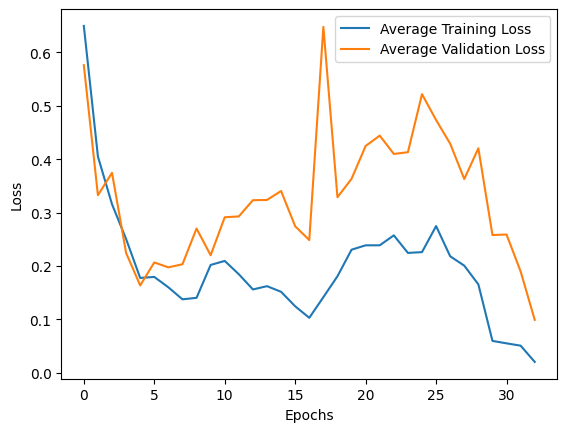

In [79]:
# Pad the training and validation histories to a common length
padded_train_histories = pad_sequences(all_train_histories, padding='post', truncating='post', dtype='float32')
padded_val_histories = pad_sequences(all_val_histories, padding='post', truncating='post', dtype='float32')

# Calculate the average training and validation loss over folds
avg_train_loss = np.mean(padded_train_histories, axis=0)
avg_val_loss = np.mean(padded_val_histories, axis=0)

# Plot the average training and validation loss over epochs
import matplotlib.pyplot as plt

plt.plot(avg_train_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

---

## New Texts on Both Models

In [51]:
bbc_snippet = """The UK faces another five years of high interest rates to stem rising prices, an influential global group has warned.
The International Monetary Fund expects the UK to have the highest inflation and slowest growth next year of any G7 economy including the US, France, Germany, Canada, Italy and Japan.
However, the Treasury said recent revisions to UK growth had not been factored in to the IMF's report.
The outlook was drawn up before this weekend's developments in Israel.
Forecasts are never perfect given the many factors that affect economic growth - from geopolitics to the weather. But such reports can point in the right direction, especially where they align with other forecasts.
The IMF, an international organisation with 190 member countries, has said the forecasts it makes for growth the following year in most advanced economies have, more often than not, been within about 1.5 percentage points of what actually happens.
In July last year, it forecast that the UK economy would grow by 3.2% in 2022. It revised that upwards to 4.1% at the start of this year.
But official UK figures released last month estimated that the country's economy actually expanded by 4.3% in 2022.
According to the IMF's latest forecast which it produces every six months, it expects the UK to grow more quickly than Germany in 2023, keeping the UK out of bottom place for growth among the G7.
But it downgraded the UK's prospects for growth next year, estimating the economy will grow by 0.6%, making it the slowest growing developed country in 2024 - widely predicted to be a general election year."""


In [52]:
theonion_snippet = """Claiming they had already made up their minds, area man Karl Wooley told reporters Tuesday 
that he felt like the bystanders who were urging him to put his gun down were arguing in bad faith. “If I’m being 
honest, it sort of feels like these onlookers are only thinking of themselves when they tell me to drop my pistol,” said Wooley, who observed that no one had even asked him to explain his reasoning for shouting at the top of his lungs and waving around a semiautomatic firearm. “Truth be told, they poisoned the well the second they tried to tackle me and forcibly rip the gun from my hands. But the worst part is how condescending they are—saying things like, ‘Hey, buddy, you don’t really want to do this.’ Maybe if they’d bothered to find out where I’m coming from and what my thoughts on the matter are, they’d know this is exactly what I want to be doing.” At press time, Wooley was reportedly shaking his head at how disrespectful his victims had become when they began resorting to ad hominem attacks like “You’re a monster” as he shot them to death."""

In [58]:
import spacy
from spacy.lang.en import English
from nltk.corpus import stopwords
import nltk
import time

## download the dictionary for stopwords
nltk.download('stopwords')

## get the set of stopwords 
stop_words_set = set(stopwords.words('english'))

## Load English tokenizer from spacy
nlp = English()
spacy_tokenizer = nlp.tokenizer ## make instance 

## Create function to clean text -- lowercase, remove non alphanumeric, remove stop words
def optimized_preprocess(texts): ## Takes in a list of texts, i.e. the entire corpus
    result = []
    
    # Tokenize using spaCy's tokenizer
    for text in texts:
        tokens = [token.text.lower() for token in spacy_tokenizer(text) if token.text.isalpha() and token.text.lower() not in stop_words_set]
        result.append(" ".join(tokens))
    
    return result

[nltk_data] Downloading package stopwords to /Users/maria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [59]:
bbc_cleaned = optimized_preprocess([bbc_snippet])
theonion_cleaned = optimized_preprocess([theonion_snippet])


In [53]:
# bbc = pd.Series([bbc_snippet])
# onion = pd.Series([theonion_snippet])

In [54]:
# bbc_clean = bbc.apply(cleaning)
# onion_clean = onion.apply(cleaning)

In [60]:
bbc_cleaned = optimized_preprocess([bbc_snippet])
theonion_cleaned = optimized_preprocess([theonion_snippet])


In [62]:
bbc_seq = tokenizer.texts_to_sequences(bbc_cleaned)
theonion_seq = tokenizer.texts_to_sequences(theonion_cleaned)


In [63]:
bbc_pad = pad_sequences(bbc_seq, maxlen= avg_length_text, padding = 'post', truncating = 'post')
theonion_pad = pad_sequences(theonion_seq, maxlen=  avg_length_text, padding = 'post', truncating = 'post')

In [64]:
# print(model_3.predict(bbc_pad))
# print(model_3.predict(theonion_pad))

# print('\n\n ======================= \n\n')

print(model_rnn.predict(bbc_pad))
print(model_rnn.predict(theonion_pad))


1/1 [==============================] - 0s 31ms/step
[[0.01258292]]
1/1 [==============================] - 0s 30ms/step
[[0.9770421]]
